# Equity Premium forecast with Random Forest

In this notebook I attempt to predict the log equity premium of the US stock market using a Random Forest model (tuning with grid search), and compare results to the benchmark unconditional mean model. Forecast horizons at 1-, 3-, 6-, and 12-month ahead. <br>
Target variable and predictor dataset from Prof. Amit Goyal's website: [Link](https://docs.google.com/spreadsheets/d/1OArfD2Wv9IvGoLkJ8JyoXS0YMQLDZfY2/edit?usp=sharing&ouid=113571510202500088860&rtpof=true&sd=true), [(Welch & Goyal, 2008)](https://drive.google.com/file/d/1uvjBJ9D09T0_sp7kQppWpD-xelJ0KQhc/view?usp=sharing)<br>
Additional predictors from FRED-MD: [Link](https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv), [Paper](https://research.stlouisfed.org/wp/more/2015-012)

## Contents:
1) Import dependencies and set seed <br>
2) Load data<br>
3) Preprocessing<br>
4) Function for walk-forward validation with expanding window<br>
5) Check stationarity of target variable<br>
6) Create naive forecasts as benchmark<br>
7) Random Forest regressor (grid search for hyperparameters)<br>
8) Results

## 1) Import dependencies and set seed

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## 2) Load data

- Import Goyal & Welch (2008) updated dataset from 2021 and change index to date.
- Additional monthly macroeconomic variables from FRED-MD.
- Limit data to 1960-2021 because of missing data.

In [3]:
data = pd.read_excel('C:/Users/user/Documents/coding/PredictorData2021.xlsx')
data = data[data.yyyymm>195911]
data.yyyymm = pd.to_datetime(data.yyyymm, format = '%Y%m')
data = data.set_index('yyyymm')

# Creating the logged equity premium from 1st differencing log stock index, then deducting risk-free rate.
data['logeqp'] = np.log(data.Index)-np.log(data.Index.shift(1))-data.Rfree

# Import FRED-MD features and change index to date
data2 = pd.read_csv('C:/Users/user/Documents/coding/current.csv')[1:]
data2.sasdate = pd.to_datetime(data2.sasdate, format = '%m/%d/%Y')
data2 = data2.set_index('sasdate')

# Separate the target variable
data = data.join(data2, how='left', rsuffix='dup')[1:]
y = data.logeqp

C:\Users\user\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## 3) Check stationarity of target variable
- Use the ACF, PACF, and Breusch-Godfrey test to check for serial correlation, for possible ARMA modelling 
- Use ADF and KPSS tests to check for stationarity, for additional differencing or GARCH modelling 

The Breusch Godfrey test has a p-value of 0.647 > 0.05, thus we cannot reject the null hypothesis of no serial correlation.
ADF test p-value: 3.5665219846994114e-19 
KPSS test p-value: 0.09443713910910272


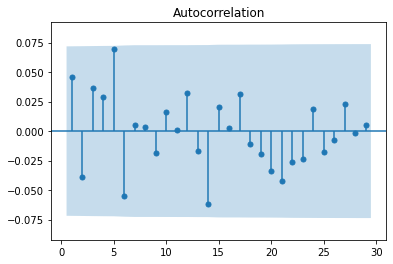

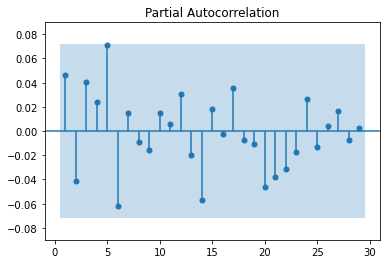

In [4]:
#%% EDA
# Check ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y,zero=False,auto_ylims=True)
plot_pacf(y,zero=False,auto_ylims=True,method='ywm')
# No significant correlation between lags of target variable at the 5% level. 
# Plots don't reveal evidence of a significant cyclical trend.

from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
# placeholder class so we can actually use the statsmodels Breusch-Godfrey test package
class holder:
    def __init__(self, resid, exog):
        self.model = self
        self.resid = resid
        self.exog = exog
bgtestres = bgtest(holder(y.subtract(y.mean()),np.ones(744)),nlags=12) 
# instantiate the placeholder class with mean-centred target as residual and a constant as the exogenous variable.
# this mimics the result of an OLS regression on a constant.
print(f'The Breusch Godfrey test has a p-value of {round(bgtestres[1],3)} > 0.05, thus we cannot reject the null hypothesis of no serial correlation.')


from statsmodels.tsa.stattools import adfuller,kpss 
print(f'ADF test p-value: {adfuller(y, autolag="AIC")[1]} \nKPSS test p-value: {kpss(y, regression="c", nlags="auto")[1]}')
# ADF test shows that the process is stationary; KPSS test shows that we cannot reject the null hypothesis that the process is stationary (at the 5% level).

## 4) Preprocessing
- Backfill for isolated NA values
- Remove highly-correlated variables

In [23]:
# dealing with NA values
x = data.drop(['logeqp', 'Index'], axis=1)
x.loc[:,['CP3Mx','COMPAPFFx']] = x.loc[:,['CP3Mx','COMPAPFFx']].fillna(method='bfill')
x = x.dropna(axis=1)

# Removing high-correlation (rho>0.9) variables

# this creates an upper triangle matrix of boolean True values above the diagonal, and False otherwise.  
booltriangle = np.triu(np.ones(x.corr().shape),k=1).astype(bool)
# we use the triangle to avoid the main matrix diagonal, where all correlations are 1, and drop variables where correlation>0.9
corr = x.corr().where(booltriangle).applymap(lambda x: True if abs(x)>0.90 else False)
to_drop = [i for i in corr.columns if any(corr[i])]+['HOUST','PERMIT'] # drop these columns to prevent multicollinearity
x = x.drop(to_drop, axis=1)

print(x.shape)

(744, 38)


## 5) Function for walk-forward validation with expanding window
- The valscore function calculates the RMSE with a list of predictions as input.
- The ewpred function inputs an sklearn estimator as 'model', intended forecast horizon as 'step', test size as 'n_test', and  predictor/target variables as 'x' and 'y'. Function outputs a list of predictions. 
- Test data is the n_test rows at the tail end of the dataset.
- The function first standardises the training predictors, then fits the model on it. It then includes the test predictor data, re-standardises, and makes a prediction based on the newly-standardised test predictors. The idea is to prevent data leakage from standardising all predictor data together.

In [24]:
from sklearn.preprocessing import StandardScaler

def valscore(preds):
    actual = y[-len(preds):]
    return np.sqrt(sum((preds-actual)**2))

def ewpred(model, step, n_test, x, y):
    preds = []
    # y_t+step for x_t
    y = y.shift(-step)[:-step]
    x = x[:-step]
    for i in range(n_test):
        # train-test split
        idx = len(x)-n_test+i
        trainx, trainy = x[:idx], y[:idx]
        testx = x[:idx+1]
        trainx = StandardScaler().fit_transform(trainx)
        mod = model.fit(trainx,trainy)
        # standardise the window with the test data separately to prevent data leakage
        testx = StandardScaler().fit_transform(testx)[-1:]
        preds.append(mod.predict(trainx)[0]) # predictions come in a numpy array so you have to fish it out
    return preds

## 6) Create naive forecasts as benchmark
- Unconditional Mean (rolling window)
- Random walk without drift

In [25]:
# Here we set the validation set as the last 100 observations, leaving a training set of 644 observations     
n_test = 100
n_train = len(x)-n_test

# Unconditional mean:
# set the min. window size to 633
mean = y.expanding(633).mean()
mean1, mean3, mean6, mean12 = mean.shift(1).dropna(), mean.shift(3).dropna(), mean.shift(6).dropna(), mean.shift(12).dropna()

# RW forecasts are a simple shift and trim:
rw1, rw3, rw6, rw12 = y.shift(1)[-n_test:], y.shift(3)[-n_test:], y.shift(6)[-n_test:], y.shift(12)[-n_test:]

scores = pd.DataFrame({'RW':[valscore(rw1),valscore(rw3),valscore(rw6),valscore(rw12)],
                       'UCMean':[valscore(mean1),valscore(mean3),valscore(mean6),valscore(mean12)],
                       }, index=['1-step','3-step','6-step','12-step'])

print(scores)

               RW    UCMean
1-step   0.587981  0.412254
3-step   0.567754  0.411627
6-step   0.563643  0.408649
12-step  0.573898  0.402200


RMSE scores show that the unconditional mean is a better benchmark model.

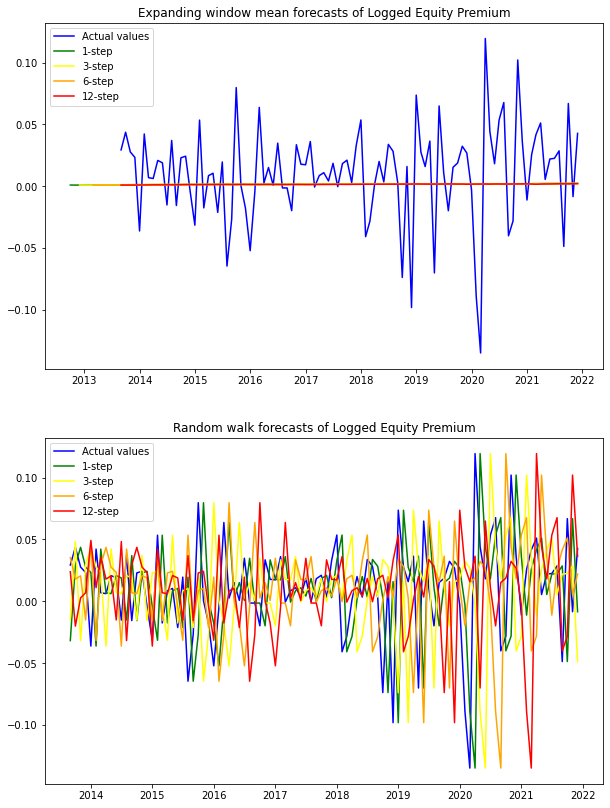

In [26]:
# Visualise
fig1, axs = plt.subplots(2, figsize=(10,14))
axs[0].plot(y[-n_test:], color='blue', label='Actual values')
axs[0].plot(mean1, color='green', label='1-step')
axs[0].plot(mean3, color='yellow', label='3-step')
axs[0].plot(mean6, color='orange', label='6-step')
axs[0].plot(mean12, color='red', label='12-step')
axs[0].set_title('Expanding window mean forecasts of Logged Equity Premium')
axs[0].legend()

axs[1].plot(y[-n_test:], color='blue', label='Actual values')
axs[1].plot(rw1, color='green', label='1-step')
axs[1].plot(rw3, color='yellow', label='3-step')
axs[1].plot(rw6, color='orange', label='6-step')
axs[1].plot(rw12, color='red', label='12-step')
axs[1].set_title('Random walk forecasts of Logged Equity Premium')
axs[1].legend()

## 7) Random Forest regressor (grid search for hyperparameters)
- Implement grid search on the training data for our random forest model

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV as gscv, TimeSeriesSplit as tss

rfparam = {'n_estimators':np.arange(400,701,100), 'max_depth':np.arange(4,13,2)}
rfgscv = gscv(RandomForestRegressor(random_state=666), param_grid=rfparam, cv=tss(n_splits=5), n_jobs=-1)
rfgscv.fit(x[:645],y[:645])
rfbp = rfgscv.best_params_

In [28]:
rf = RandomForestRegressor(n_estimators=rfbp['n_estimators'],max_depth=rfbp['max_depth'],random_state=666,n_jobs=-1)
rf1, rf3, rf6, rf12 = [pd.Series(ewpred(rf,i,n_test,x,y), index=y[-n_test:].index) for i in [1,3,6,12]]
scores['Randomforest'] = [valscore(i) for i in [rf1,rf3,rf6,rf12]]
print(scores)

               RW    UCMean  Randomforest
1-step   0.587981  0.412254      0.407115
3-step   0.567754  0.411627      0.407773
6-step   0.563643  0.408649      0.403695
12-step  0.573898  0.402200      0.408868


The Random Forest model outperforms the Unconditonal Mean model at every forecast horizon except the 12-step ahead one. This is not unexpected, given that the longer the forecast horizon, the poorer the predictive power of models; on the other hand mean reversion of the equity premium means that the unconditional mean sees increasing success with longer forecast horizons.

Text(0.5, 0.98, 'Random forest forecasts')

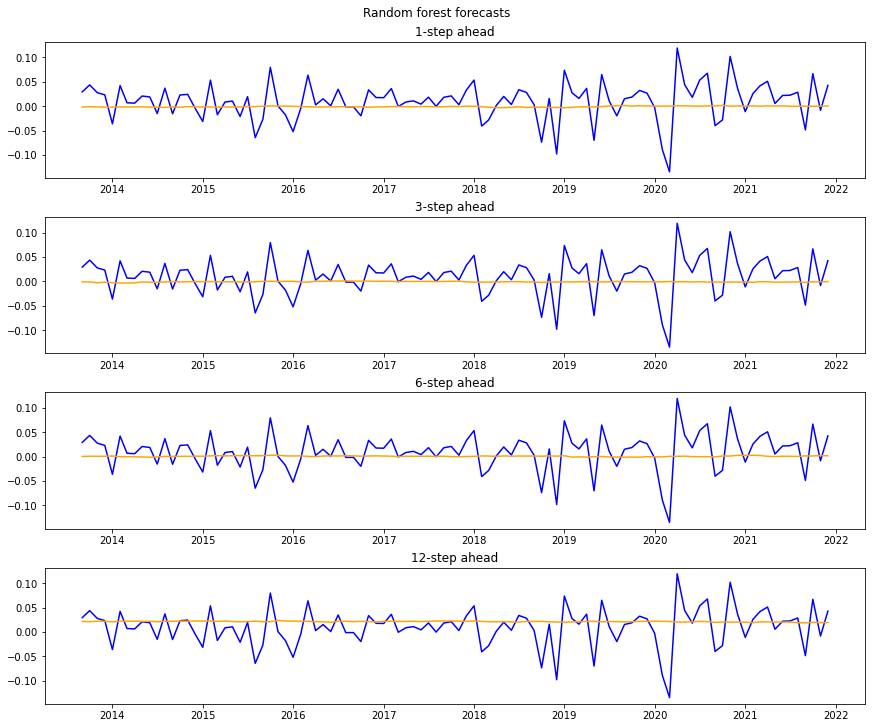

In [29]:
#Visualise
figrf, axsrf = plt.subplots(4, figsize=(12,10), layout='constrained')
for i in range(4):
    axsrf[i].plot(y[-n_test:],color='blue')
axsrf[0].plot(rf1, color='orange')
axsrf[0].set_title('1-step ahead')
axsrf[1].plot(rf3, color='orange')
axsrf[1].set_title('3-step ahead')
axsrf[2].plot(rf6, color='orange')
axsrf[2].set_title('6-step ahead')
axsrf[3].plot(rf12, color='orange')
axsrf[3].set_title('12-step ahead')
figrf.suptitle('Random forest forecasts')

From the previous graph, the Random Forest forecast still looks like a straight line, almost indistinguishable from the unconditional mean forecast. Let's take a closer look.

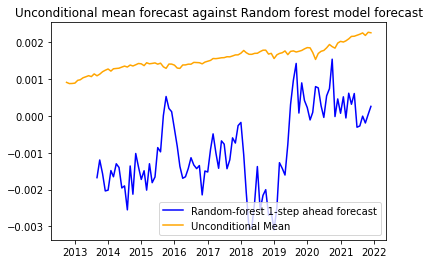

In [30]:
fig2, ax2 = plt.subplots()
ax2.plot(rf1, color='blue', label='Random-forest 1-step ahead forecast')
ax2.plot(mean1, color='orange', label='Unconditional Mean')
ax2.set_title('Unconditional mean forecast against Random forest model forecast')
ax2.legend()